Using TensorFlow backend.


The data shape is (249, 391)
Train on 224 samples, validate on 25 samples
Epoch 1/300
224/224 [==============================] - 0s 1ms/step - loss: 0.2267 - val_loss: 0.1018
Epoch 2/300
224/224 [==============================] - 0s 183us/step - loss: 0.0629 - val_loss: 0.0416
Epoch 3/300
224/224 [==============================] - 0s 174us/step - loss: 0.0427 - val_loss: 0.0329
Epoch 4/300
224/224 [==============================] - 0s 169us/step - loss: 0.0328 - val_loss: 0.0243
Epoch 5/300
224/224 [==============================] - 0s 175us/step - loss: 0.0265 - val_loss: 0.0211
Epoch 6/300
224/224 [==============================] - 0s 169us/step - loss: 0.0242 - val_loss: 0.0196
Epoch 7/300
224/224 [==============================] - 0s 156us/step - loss: 0.0223 - val_loss: 0.0174
Epoch 8/300
224/224 [==============================] - 0s 178us/step - loss: 0.0194 - val_loss: 0.0154
Epoch 9/300
224/224 [==============================] - 0s 178us/step - loss: 0.0176 - val_loss: 0.0145
E

224/224 [==============================] - 0s 174us/step - loss: 0.0064 - val_loss: 0.0058
Epoch 80/300
224/224 [==============================] - 0s 191us/step - loss: 0.0064 - val_loss: 0.0057
Epoch 81/300
224/224 [==============================] - 0s 196us/step - loss: 0.0064 - val_loss: 0.0057
Epoch 82/300
224/224 [==============================] - 0s 191us/step - loss: 0.0064 - val_loss: 0.0057
Epoch 83/300
224/224 [==============================] - 0s 165us/step - loss: 0.0065 - val_loss: 0.0059
Epoch 84/300
224/224 [==============================] - 0s 165us/step - loss: 0.0064 - val_loss: 0.0059
Epoch 85/300
224/224 [==============================] - 0s 169us/step - loss: 0.0064 - val_loss: 0.0058
Epoch 86/300
224/224 [==============================] - 0s 165us/step - loss: 0.0063 - val_loss: 0.0057
Epoch 87/300
224/224 [==============================] - 0s 156us/step - loss: 0.0063 - val_loss: 0.0057
Epoch 88/300
224/224 [==============================] - 0s 223us/step - loss:

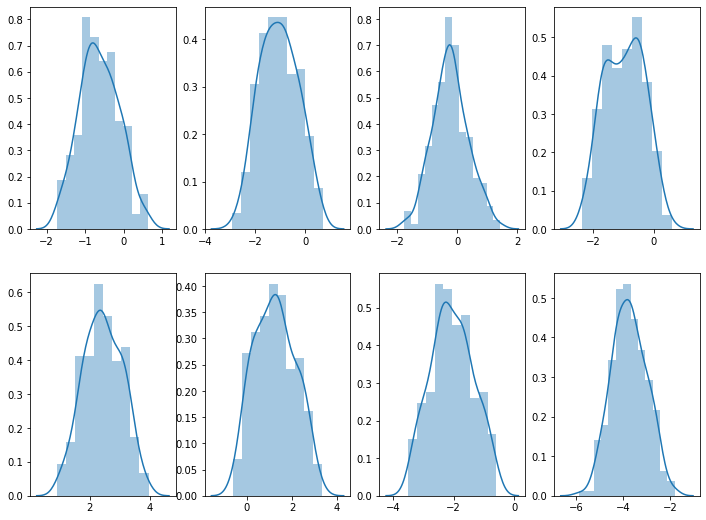

[[-1.6193777  -2.1050077  -0.0971139  -1.70260029  2.48357996  0.93495631
  -3.13242718 -4.1127125 ]]
[[-1.6193777  -2.105008   -0.09711397 -1.7026004   2.4835796   0.9349564
  -3.1324267  -4.112712  ]]


In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from keras import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Lambda, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.utils import plot_model

import pickle

import os


class AutoEncoder:
    def __init__(self, date_range, symbol="AAPL", data_file="calibration_data"):
        self.data = None
        for day in date_range:
            path = "fundamental_{}_{}.bz2".format(symbol, day.strftime("%Y%m%d"))
            path = os.path.join(data_file, path)
            if os.path.exists(path):
                prices = pd.read_pickle(path, compression="bz2")
                if self.data is None:
                    self.data = prices.values.T
                else:
                    self.data = np.vstack([self.data, prices.values.T])
        scaler = MinMaxScaler()
        self.data_scaled = np.array([scaler.fit_transform(d.reshape(-1, 1)) for d in self.data])
        self.data_scaled = self.data_scaled[:, :, 0]
        print("The data shape is", self.data_scaled.shape)

    def build_model(self, encode_length=16, activation="relu"):
        n_in = self.data_scaled.shape[1]
        self.encode_length = encode_length

        self.model = Sequential()
        self.model.add(Dense(128, activation=activation, name="encoder_l1"))
        self.model.add(Dense(64, activation=activation, name="encoder_l2"))
        self.model.add(Dense(encode_length, name="encoder_output", activation=None))
        self.model.add(Dense(64, activation=activation))
        self.model.add(Dense(128, activation=activation))
        self.model.add(Dense(n_in, activation=None))

        self.model.compile(optimizer='adam', loss='mse')
        self.model.build()

        return self.model

    def _reshape_data(self, data):
        if len(data.shape) == 3:
            return data
        if len(data.shape) == 2:
            return data[:, :, np.newaxis]
        if len(data.shape) == 1:
            return data[np.newaxis, :, np.newaxis]

    def train_model(self, test_size=0.1, val_size=0.1, batch_size=16, epochs=200, stop_patience=10, plot_test=True,
                    plot_history=True):
        x = self.data_scaled
        if test_size != 0.:
            x_train, x_test, y_train, y_test = train_test_split(x, x, test_size=test_size, random_state=42)
            print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        else:
            x_train, y_train = x, x

        early_stopping = EarlyStopping(monitor='val_loss', patience=stop_patience, mode="min", verbose=2,
                                       restore_best_weights=True)
        result = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                                validation_split=val_size / (1 - test_size), callbacks=[early_stopping])
        if plot_test:
            y_test_predict = self.model.predict(x_test)
            print("test loss:", np.sum((y_test_predict - y_test) ** 2) / (y_test.shape[0] * y_test.shape[1]))
            plt.plot(y_test[0])
            plt.plot(y_test_predict[0])
            plt.ylabel("Scaled Price")
            plt.xlabel("Minutes")
            plt.title("Encode length {}".format(self.encode_length))
            plt.legend(["Real", "Predict"])
            plot_name = "sample"
            plt.savefig('{}_{}.png'.format(plot_name, self.encode_length))
            plt.show()
        if plot_history:
            self.loss_plot(result.history)

        return result

    def loss_plot(self, history, plot_name='Loss'):
        loss = np.asarray(history['loss'])
        val_loss = np.asarray(history['val_loss'])
        plt.style.use('seaborn')
        plt.figure(figsize=(12, 9), dpi=100)
        plt.grid(True)
        plt.plot(loss)
        plt.plot(val_loss)
        plt.legend(['loss', 'val_loss'])
        plt.title("Encode length {}".format(self.encode_length))
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.savefig('{}_{}.png'.format(plot_name, self.encode_length))
        plt.show()

    def save_feature(self, plot_feature=False):
        feature_name = "AutoEncoderFeature_{}.npy".format(self.encode_length)
        encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('encoder_output').output)
        feature = encoder.predict(self.data_scaled)
        np.save("feature/" + feature_name, feature)

        if plot_feature:
            if self.encode_length == 8:
                fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(12, 9))
                axes = ax.flatten()
                for i in range(feature.shape[1]):
                    sns.distplot(feature[:, i], ax=axes[i])
                plt.show()
                return

            for i in range(feature.shape[1]):
                sns.distplot(feature[:, i])
                plt.show()
            return

    def save_model(self):
        self.model.save("model/AutoEncoder_{}.h5".format(self.encode_length))

    def save_encoder_ws(self):
        w1, b1 = self.model.get_layer('encoder_l1').get_weights()
        w2, b2 = self.model.get_layer('encoder_l2').get_weights()
        w3, b3 = self.model.get_layer('encoder_output').get_weights()
        with open("model/AutoEncoder_w_{}.h5".format(self.encode_length), "wb") as f:
            pickle.dump([w1, b1, w2, b2, w3, b3], f)

    def encode(self, x):
        encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('encoder_output').output)
        return encoder.predict(x)


if __name__ == "__main__":
    date_range = pd.date_range(start='1/1/2019', end='12/31/2019', freq="D")
    encode_length = 8
    AE = AutoEncoder(date_range)
    AE.build_model(encode_length=encode_length, activation="relu")
    # AE.train_model(test_size=0.1, val_size=0.1, plot_test=True, batch_size=16, plot_history=True, epochs=300,
    #                stop_patience=20)
    # plot_model(AE.model, to_file='autoencoder_{}.png'.format(encode_length), show_shapes=True)
    AE.train_model(test_size=0., val_size=0.1, plot_test=False, plot_history=False, epochs=300, stop_patience=20)
    AE.save_model()
    AE.save_encoder_ws()
    AE.save_feature(plot_feature=True)

    x_test = AE.data_scaled[0]

    with open("model/AutoEncoder_w_{}.h5".format(encode_length), "rb") as f:
        params = pickle.load(f)

    def encoder(params, x):
        [w1, b1, w2, b2, w3, b3] = params
        activation = np.vectorize(lambda x: max(0., x))
        return activation(activation(x @ w1 + b1) @ w2 + b2) @ w3 + b3

    print(encoder(params,np.array([x_test])))
    print(AE.encode(np.array([x_test])))
